In [1]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb

In [21]:
# =========  ===================================
# run        task
# =========  ===================================
# 1          Baseline, eyes open
# 2          Baseline, eyes closed
# 3, 7, 11   Motor execution: left vs right hand
# 4, 8, 12   Motor imagery: left vs right hand
# 5, 9, 13   Motor execution: hands vs feet
# 6, 10, 14  Motor imagery: hands vs feet
# =========  ===================================

subject = 1

runs1 = [4, 8, 12]

edf_paths1 = [f"/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S{subject:03d}/S{subject:03d}R{run:02d}.edf" for run in runs1]
print(edf_paths1)

runs2 = [6, 10, 14]

edf_paths2 = [f"/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S{subject:03d}/S{subject:03d}R{run:02d}.edf" for run in runs2]
print(edf_paths2)

['/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R04.edf', '/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R08.edf', '/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R12.edf']
['/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R06.edf', '/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R10.edf', '/home/txdat/mne_data/MNE-eegbci-data/pn4/eegmmidb/S001/S001R14.edf']


In [22]:
raw1 = mne.concatenate_raws([mne.io.read_raw_edf(edf_path, preload=True, verbose=False) for edf_path in edf_paths1])
mne.datasets.eegbci.standardize(raw1)
raw1.set_montage("standard_1005")

<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [23]:
raw2 = mne.concatenate_raws([mne.io.read_raw_edf(edf_path, preload=True, verbose=False) for edf_path in edf_paths2])
mne.datasets.eegbci.standardize(raw2)
raw2.set_montage("standard_1005")

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [4]:
raw = raw1

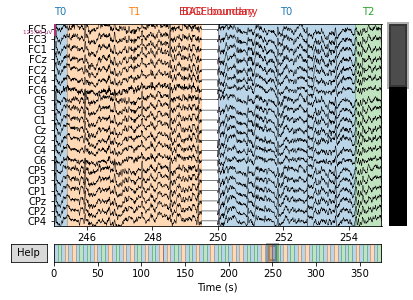

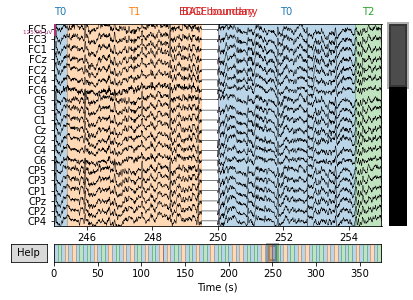

In [131]:
raw.plot(scalings="auto", start=245)

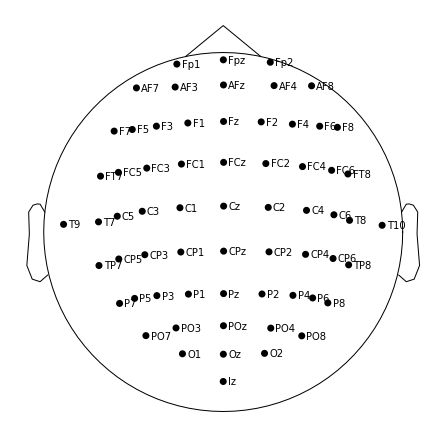

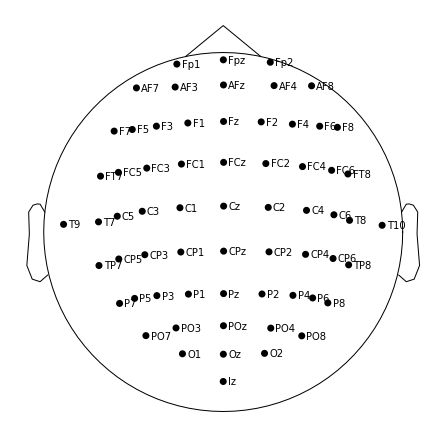

In [5]:
raw.plot_sensors(show_names=True)

In [115]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [114]:
annot = pd.DataFrame(raw.annotations)
# annot["label"] = ""
# for i, label in enumerate(["rest", "left_hand", "right_hand"]):
#     for idx in annot[annot["description"] == f"T{i}"].index:
#         annot.loc[idx, "label"] = label
    
annot

,onset,duration,description,orig_time
0,0.0,4.2,T0,2009-08-12 16:15:00+00:00
1,4.2,4.1,T2,2009-08-12 16:15:00+00:00
2,8.3,4.2,T0,2009-08-12 16:15:00+00:00
3,12.5,4.1,T1,2009-08-12 16:15:00+00:00
4,16.6,4.2,T0,2009-08-12 16:15:00+00:00
...,...,...,...,...
185,728.8,4.1,T2,2009-08-12 16:15:00+00:00
186,732.9,4.2,T0,2009-08-12 16:15:00+00:00
187,737.1,4.1,T1,2009-08-12 16:15:00+00:00
188,741.2,4.2,T0,2009-08-12 16:15:00+00:00


In [5]:
events, event_id = mne.events_from_annotations(raw)

event_id

Used Annotations descriptions: ['T0', 'T1', 'T2']


{'T0': 1, 'T1': 2, 'T2': 3}

In [6]:
rawf = raw.copy().filter(l_freq=8.0, h_freq=30, verbose=False)

In [10]:
picks = mne.pick_channels(ch_names=rawf.info["ch_names"], include=[
   "F3", "Fz", "F4",
   "FC5", "FC1", "FC2", "FC6",
   "C3", "Cz", "C4",
   "CP5", "CP1", "CP2", "CP6",
   "P3", "Pz", "P4",
], ordered=True)

epochs = mne.Epochs(
    rawf,
    events[np.where(events[:, -1] == 1)[0]],
    event_id=event_id,
    tmin=0,
    tmax=2,
    proj=False,
    baseline=None,
    preload=True,
    verbose=False,
    picks=picks,
    event_repeated="drop",
    on_missing="ignore",
)

    Using multitaper spectrum estimation with 7 DPSS windows


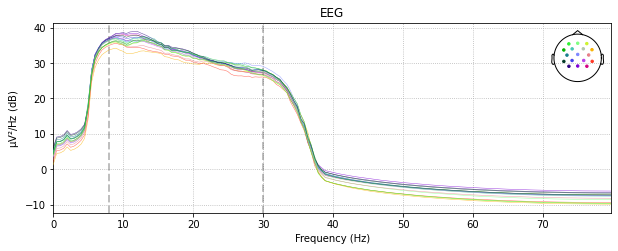

    Using multitaper spectrum estimation with 7 DPSS windows


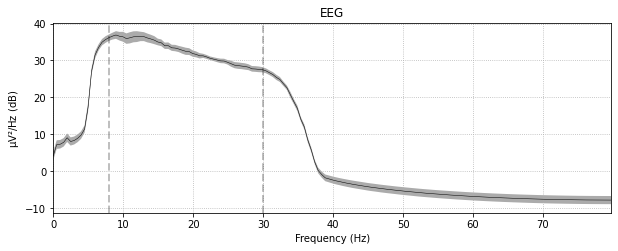

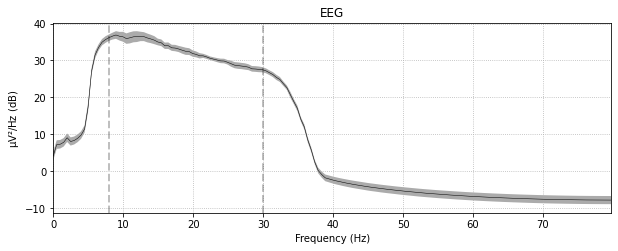

In [11]:
epochs.plot_psd(average=False)
epochs.plot_psd(average=True)

In [12]:
freq_range = np.arange(8, 30)

power = mne.time_frequency.tfr_multitaper(epochs, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                          return_itc=False, average=True, decim=2)

No baseline correction applied
No baseline correction applied


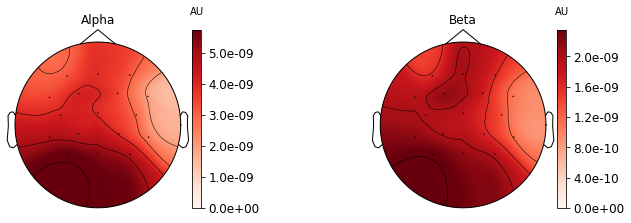

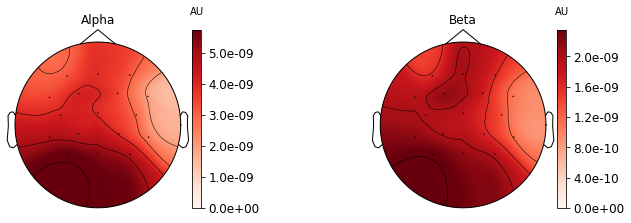

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(12, 3))

power.plot_topomap(ch_type='eeg', fmin=8, fmax=12,
                   mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='eeg', fmin=12, fmax=30,
                   mode='logratio', axes=axis[1],
                   title='Beta', show=False)

No baseline correction applied


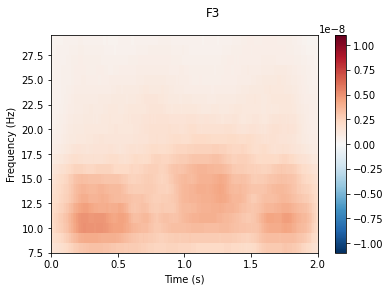

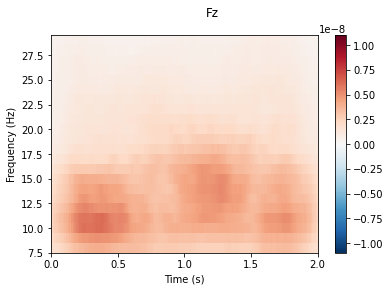

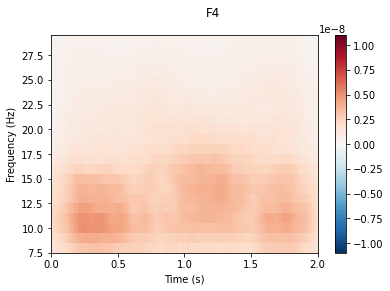

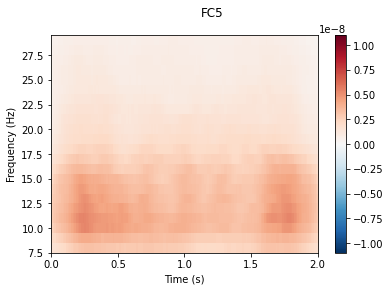

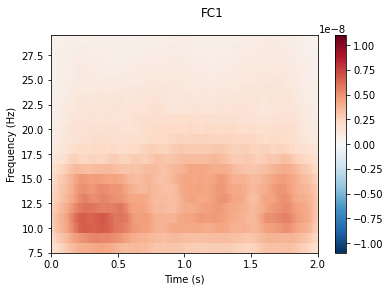

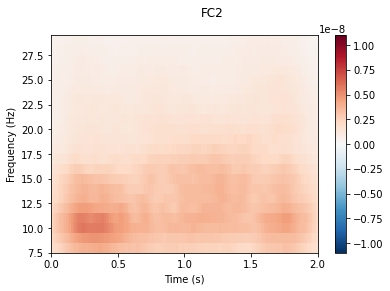

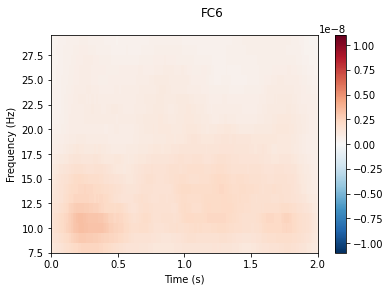

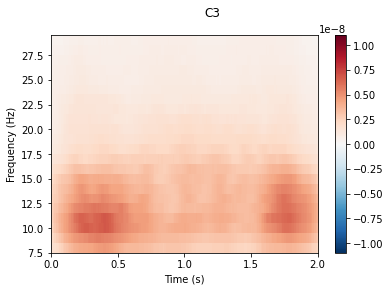

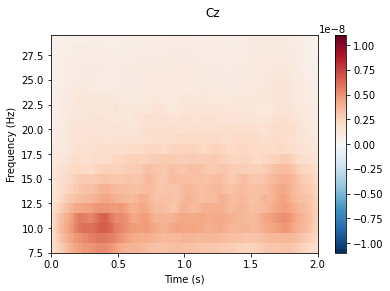

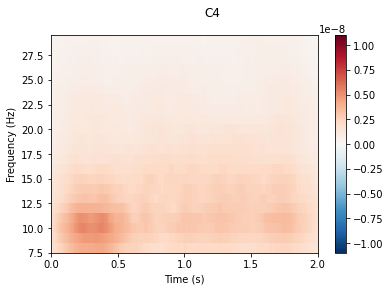

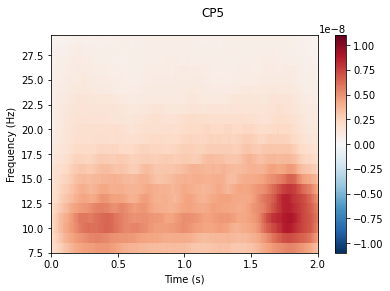

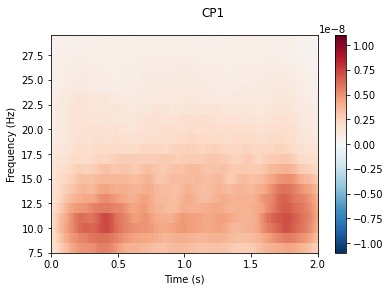

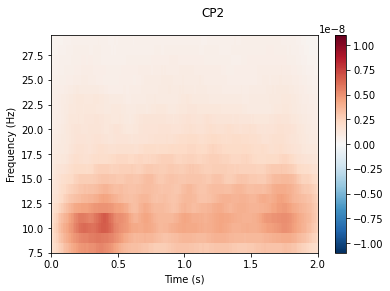

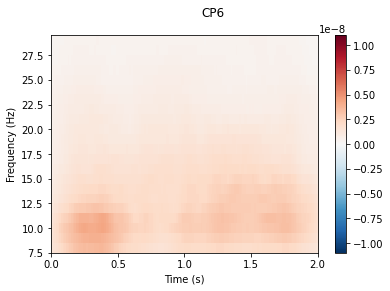

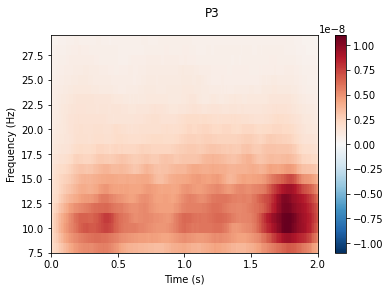

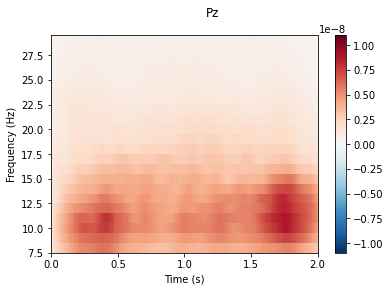

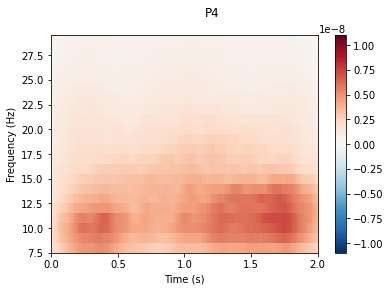

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [14]:
power.plot(title="auto", mode="logratio")

No baseline correction applied
No baseline correction applied


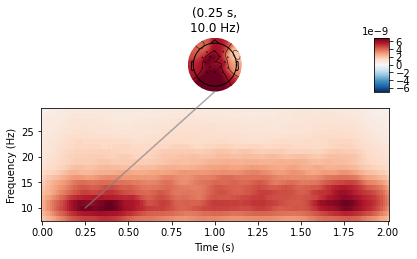

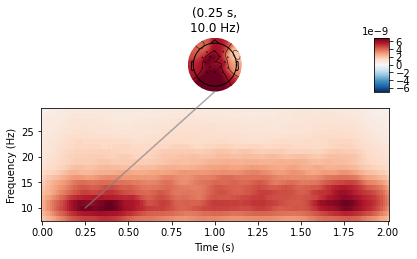

In [15]:
power.plot_joint()

In [24]:
picks = mne.pick_channels(ch_names=rawf.info["ch_names"], include=[
   "F3", "Fz", "F4",
   "FC5", "FC1", "FC2", "FC6",
   "C3", "Cz", "C4",
   "CP5", "CP1", "CP2", "CP6",
   "P3", "Pz", "P4",
], ordered=True)

In [11]:
epochs = mne.Epochs(
    rawf,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=4,
    proj=False,
    baseline=None,
    preload=True,
    verbose=False,
    picks=picks,
    event_repeated="drop",
    on_missing="ignore",
)

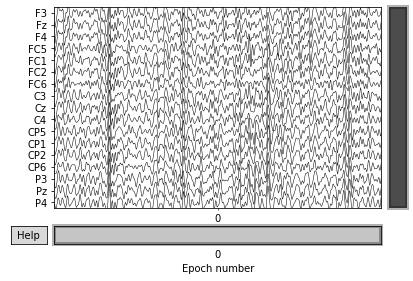

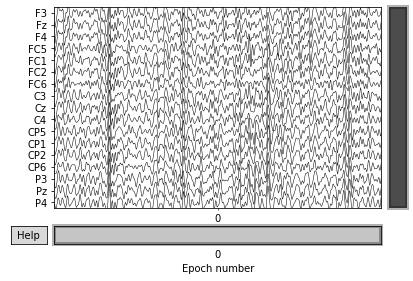

In [12]:
epochs[0].plot(scalings="auto")

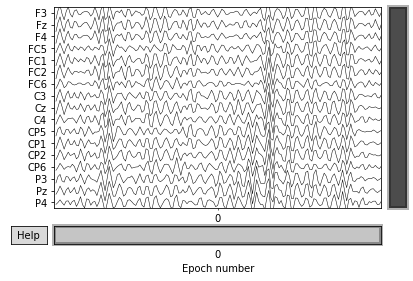

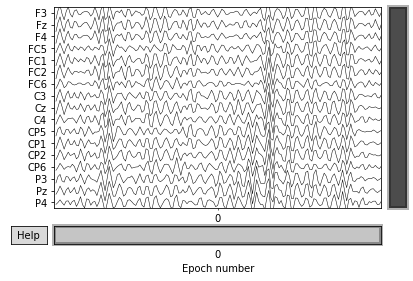

In [13]:
epochs.copy().filter(l_freq=8.0, h_freq=12.0)[0].plot(scalings="auto")

In [14]:
rawf2 = raw.copy().filter(l_freq=8.0, h_freq=12.0, verbose=False)

epochs2 = mne.Epochs(
    rawf2,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=4,
    proj=False,
    baseline=None,
    preload=True,
    verbose=False,
    picks=picks,
    event_repeated="drop",
    on_missing="ignore",
)

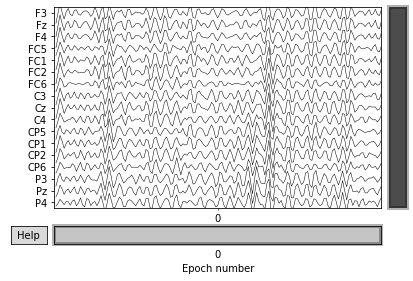

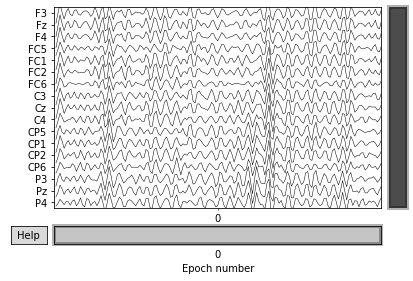

In [15]:
epochs2[0].plot(scalings="auto")

In [16]:
x1 = epochs.copy().filter(l_freq=8.0, h_freq=12.0).get_data()
x2 = epochs2.get_data()
x3 = mne.filter.filter_data(epochs.get_data(), sfreq=epochs.info["sfreq"], l_freq=8.0, h_freq=12.0, verbose=False)

x1.shape, x2.shape, x3.shape

((90, 17, 641), (90, 17, 641), (90, 17, 641))

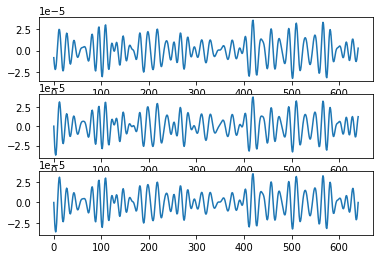

In [20]:
i = 0
c = 0

_, axes = plt.subplots(ncols=1, nrows=3)
axes[0].plot(range(x1.shape[-1]), x1[i, c])
axes[1].plot(range(x2.shape[-1]), x2[i, c])
axes[2].plot(range(x3.shape[-1]), x3[i, c])

In [132]:
raw1f = raw1.copy().filter(l_freq=8.0, h_freq=30.0)
raw2f = raw2.copy().filter(l_freq=8.0, h_freq=30.0)

In [26]:
events1, event_id1 = mne.events_from_annotations(raw1)

epochs1 = mne.Epochs(
    raw1,
    events=events1,
    event_id=event_id1,
    tmin=0,
    tmax=4,
    proj=False,
    baseline=None,
    preload=True,
    verbose=False,
    picks=picks,
    event_repeated="drop",
    on_missing="ignore",
)

epochs1.event_id = {"rest": 1, "left_hand": 2, "right_hand": 3}

events2, event_id2 = mne.events_from_annotations(raw2)

epochs2 = mne.Epochs(
    raw2,
    events=events2,
    event_id=event_id2,
    tmin=0,
    tmax=4,
    proj=False,
    baseline=None,
    preload=True,
    verbose=False,
    picks=picks,
    event_repeated="drop",
    on_missing="ignore",
)

epochs2.event_id = {"rest": 1, "hands": 4, "feet": 5}

lbl = epochs2.events[:, -1]
lbl[np.where(lbl == 2)[0]] = 4
lbl[np.where(lbl == 3)[0]] = 5

epochs2.events[:, -1] = lbl

Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']


In [28]:
epochs = mne.concatenate_epochs((epochs1, epochs2))
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, FC5, FC1, FC2, FC6, C3, Cz, C4, CP5, CP1, CP2, CP6, ...
 chs: 17 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 17
 projs: []
 sfreq: 160.0 Hz
>

In [30]:
x = epochs.get_data()
y = epochs.events[:, -1]

idx = np.where(y > 1)[0]
x = x[idx]
y = y[idx] - 2

x.shape, y.shape

((90, 17, 641), (90,))

In [31]:
idx = np.arange(len(x))
np.random.shuffle(idx)

x = x[idx]
y = y[idx]

In [33]:
n = 15
np.bincount(y[:-n]), np.bincount(y[-n:])

(array([19, 19, 16, 21]), array([4, 3, 5, 3]))

In [34]:
from fbcsp import FBCSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, classification_report

In [65]:
clf = make_pipeline(
    FBCSP(
        filters=[(8, 12), (12, 16), (16, 20), (20, 24), (24, 28)],
        filter_order=0,
        sfreq=raw.info["sfreq"],
        n_components=4,
#         reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ),
    LinearSVC(
        C=1.0,
#         kernel="rbf",
        tol=1e-7,
        max_iter=30000,
        class_weight="balanced",
        random_state=42,
    ),
#     LinearDiscriminantAnalysis(
#         solver="lsqr",
#         shrinkage="auto",
#         n_components=None,
#         tol=1e-7,
#         covariance_estimator=None,
#     ),
)

In [66]:
%%time

clf.fit(x[:-n], y[:-n])

Computing rank from data with rank=None
    Using tolerance 2.1e-05 (2.2e-16 eps * 17 dim * 5.5e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-05 (2.2e-16 eps * 17 dim * 5.6e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-05 (2.2e-16 eps * 17 dim * 5.4e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 17 dim * 6.3e+09  max singular value)
  

/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


Computing rank from data with rank=None
    Using tolerance 1.8e-05 (2.2e-16 eps * 17 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-05 (2.2e-16 eps * 17 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 17 dim * 4.6e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-05 (2.2e-16 eps * 17 dim * 5.6e+09  max singular value)


/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 17 dim * 3.9e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 17 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 17 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 17 dim * 3.9e+09  max singular value)


/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 17 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 17 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 17 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.


/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


Computing rank from data with rank=None
    Using tolerance 9.5e-06 (2.2e-16 eps * 17 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-06 (2.2e-16 eps * 17 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-06 (2.2e-16 eps * 17 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 17
    MAG: rank 17 computed from 17 data channels with 0 projectors
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 17 dim * 2.8e+09  max singular value)


/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


CPU times: user 4.82 s, sys: 2.25 s, total: 7.07 s
Wall time: 5.28 s


Pipeline(steps=[('fbcsp',
                 FBCSP(filter_order=0,
                       filters=[(8, 12), (12, 16), (16, 20), (20, 24),
                                (24, 28)],
                       sfreq=160.0)),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', max_iter=30000,
                           random_state=42, tol=1e-07))])

In [67]:
np.bincount(y[-n:])

array([4, 3, 5, 3])

In [68]:
pred = clf.predict(x[-n:])

In [69]:
confusion_matrix(y_true=y[-n:], y_pred=pred)

array([[3, 1, 0, 0],
       [0, 3, 0, 0],
       [1, 0, 3, 1],
       [0, 0, 0, 3]])

In [70]:
print(classification_report(y_true=y[-n:], y_pred=pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      1.00      0.86         3
           2       1.00      0.60      0.75         5
           3       0.75      1.00      0.86         3

    accuracy                           0.80        15
   macro avg       0.81      0.84      0.80        15
weighted avg       0.83      0.80      0.79        15



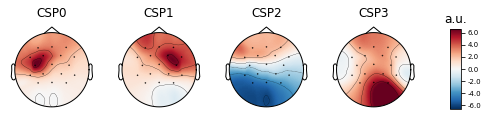

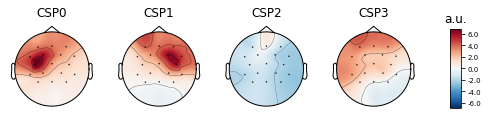

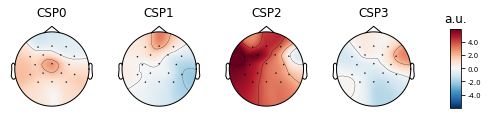

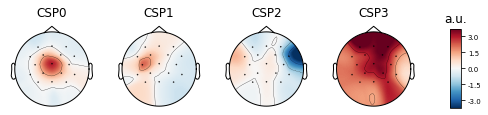

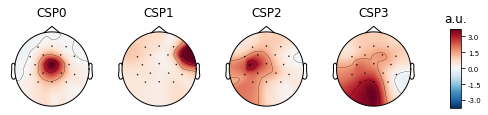

In [71]:
for csp in clf[0].filt_csp:
    csp.plot_patterns(epochs.info)

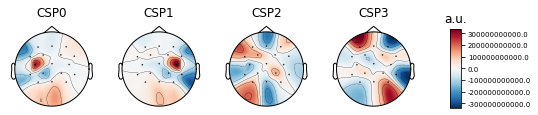

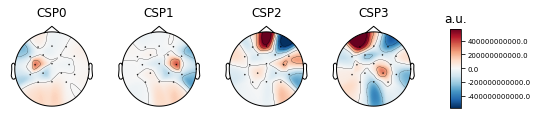

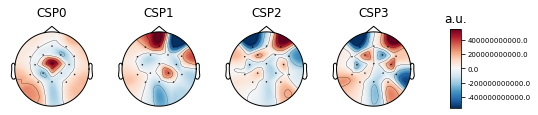

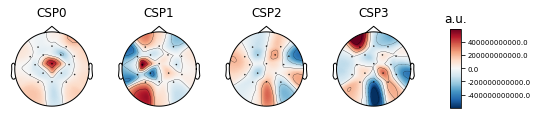

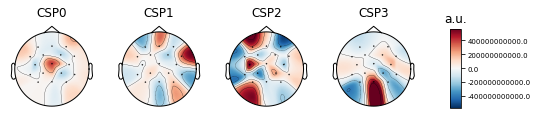

In [72]:
for csp in clf[0].filt_csp:
    csp.plot_filters(epochs.info)